## REDOR fitting

#### Load data

#### Define data and experiment

In [1]:
import os
from dotenv import load_dotenv
import nmrglue as ng
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.constants import pi
from scipy.constants import physical_constants
from scipy.optimize import curve_fit
from utils import gamma
from utils.function import redor_threehalf
from utils.function import redor_bessel
from utils.function import reapdor_threehalf
from utils.function import reapdor_PB_natural_abundance

In [10]:
'''

load_dotenv()

# define data location
PREFIX = os.getenv("PREFIX")
LIB = os.getenv("LIB")
EXPNAME = os.getenv("EXPNAME")
EXPNO = os.getenv("EXPNO")
procno = '1'  # @param {type:"string"}
'''

# define data location
PREFIX = 'C:\\Bruker\\TopSpin4.1.4\\data'
LIB = 'FLP'
EXPNAME = '240619_FLP02_3p2mm_HXY700'
EXPNO = '10'
procno = '1'  # @param {type:"string"}

dir_exp = os.path.join(PREFIX, LIB, EXPNAME)
dir_proc = os.path.join(PREFIX, LIB, EXPNAME, EXPNO, 'pdata')

print("Data path: "+dir_exp)

# define processing parameters
int_width = 400
fit_mode = "integral"

# define experiment paramters
cnst10 = 2
spin_rate = 17  # in kHz

# define constants
mu_0 = physical_constants['vacuum mag. permeability'][0]
hbar = physical_constants['reduced Planck constant'][0]
gamma_I = gamma.P
gamma_S = gamma.B11

# define a guess of the distance as initial value for fitting
r_guess = 0.559  # in nm

Data path: C:\Bruker\TopSpin4.1.4\data\FLP\240619_FLP02_3p2mm_HXY700


#### Read and process all spectra

C:\Bruker\TopSpin4.1.4\data\FLP\240619_FLP02_3p2mm_HXY700\10\pdata


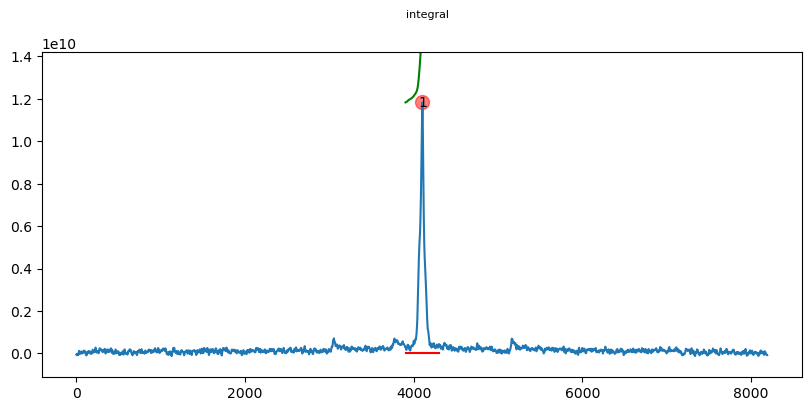

4103.0


In [6]:
# get a list of all processed spectra

procs = []
print(dir_proc)
for root, dirs, files in os.walk(dir_proc):
    for name in dirs:
        procs.append(name)

del procs[0]
num_of_procs = len(procs)
int_list = np.zeros(num_of_procs)
intensity_list = np.zeros(num_of_procs)

# read and process all spectra
first_spec = True
counter = 0
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
for procno in procs:
    
    path_proc = os.path.join(dir_proc, procno)
    dic,data = ng.bruker.read_pdata(path_proc)
    #data = data[15900:16800]

    if first_spec:
        first_spec = False
        # define peak region
        pp_threshold = data.max()/2
        peaks = ng.peakpick.pick(data, pthres=pp_threshold, algorithm="downward")
        peak_center = peaks[0]["X_AXIS"]#(peaks[0]["X_AXIS"] + peaks[1]["X_AXIS"])/2
        int_lb = int(peak_center - int_width/2)
        int_ub = int(peak_center + int_width/2)
        ax.plot(data.real)
        for n, peak in enumerate(peaks):
            height = data[int(peak["X_AXIS"])]
            ax.scatter(peak["X_AXIS"], height, marker="o", color="r", s=100, alpha=0.5)
            ax.text(peak["X_AXIS"], height+5e5, n+1, ha="center", va="center")

        intrng = data[int_lb:int_ub+1]
        intrng_scale = np.arange(0, data.shape[0], 1)[int_lb:int_ub+1]
        ax.plot(intrng_scale, intrng.cumsum()/100. + data.max(), 'g-')
        ax.plot(intrng_scale, [0]*len(intrng_scale), 'r-')
        ax.text(intrng_scale[0], 0.5*intrng.sum()/100. + data.max(), "integral", fontsize=8)

        # ax.hlines(pp_threshold, , linestyle="--", color="k")
        ax.set_ylim(top=data.max()*1.2)
        plt.show()
        
        print(peak_center)
    
    intensity_list[counter] = data.real[int(peak_center)]
    
    intrng = data[int_lb:int_ub+1]
    intrng_scale = np.arange(0, data.shape[0], 1)[int_lb:int_ub+1]
    int_list[counter] = intrng.sum()
    counter = counter+1

#### Calculate experimental REDOR points

Maximum evolution time: 2.2 ms


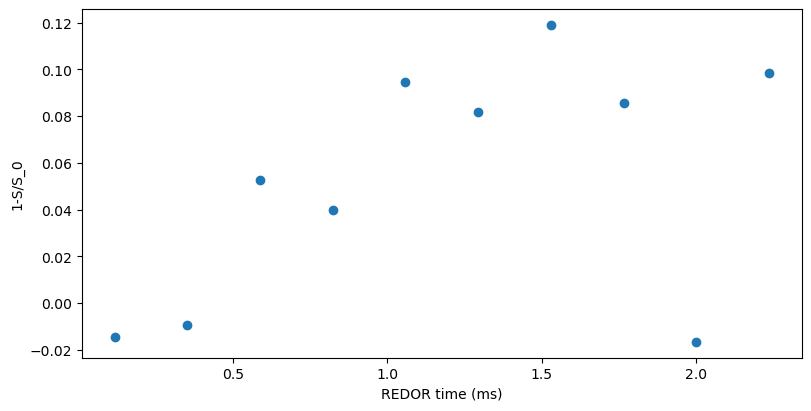

In [8]:
if fit_mode == "intensity":
    intensity_list = intensity_list.reshape(2, int(num_of_procs/2))

    diff_list = np.zeros(intensity_list.shape[1])
    redor_list = np.zeros(intensity_list.shape[1])
    for j in range(redor_list.shape[0]):
        diff_list[j] = intensity_list[1, j] - intensity_list[0, j]
        redor_list[j] = diff_list[j] / intensity_list[1, j]
elif fit_mode == "integral":
    int_list = int_list.reshape(2, int(num_of_procs/2))

    diff_list = np.zeros(int_list.shape[1])
    redor_list = np.zeros(int_list.shape[1])
    for j in range(redor_list.shape[0]):
        diff_list[j] = int_list[1, j] - int_list[0, j]
        redor_list[j] = diff_list[j] / int_list[1, j]
else:
    pass # raise error

# print(diff_list)
# print(redor_list)

# plot
# plt.plot(data)
# plt.savefig("./fig/plot.png")

# plot REDOR points
d5 = 1 / spin_rate  # in ms
time_exp = np.zeros(redor_list.shape[0])

for i in range(redor_list.shape[0]):
    time_exp[i] = 2*(cnst10*i+1)*d5
# print(time_exp)
print("Maximum evolution time: {:.1f} ms".format(time_exp[-1]))

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
ax.scatter(time_exp, redor_list)
ax.set_xlabel('REDOR time (ms)')
ax.set_ylabel('1-S/S_0')
plt.show()

#### If needed, write data points to a file

In [ ]:
filename = os.path.join("./", "data", EXPNAME + "_" + EXPNO + ".csv")
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerow(time_exp)
    csvwriter.writerow(redor_list)

#### Read data points from a file (not needed if previous cells are correctly run)

In [ ]:
# define experiment
#EXPNAME = os.getenv("EXPNAME")
#EXPNO = os.getenv("EXPNO")
filename = os.path.join("./", "data", EXPNAME + "_" + EXPNO + ".csv")
with open(filename, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    time_exp = np.array(csvreader.__next__(), dtype="double")
    redor_list = np.array(csvreader.__next__(), dtype="double")

#### Fit the REDOR curve

Dipolar coupling constant by guess = 0.089 kHz
Dipolar coupling constant by fitting = 0.142 kHz
Fitted r = 0.479 nm


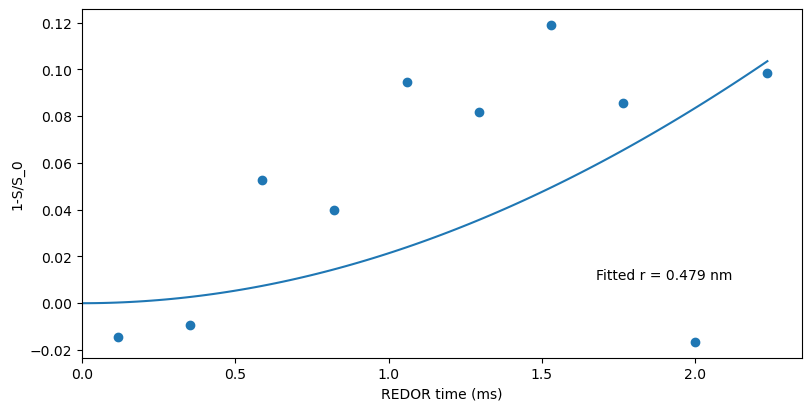

In [12]:
d_IS_guess = mu_0 / (4*pi) * (gamma_I*gamma_S*hbar) / (2*pi) / (r_guess/10**9)**3 /1000  # in kHz
print('Dipolar coupling constant by guess = {:.3f} kHz'.format(d_IS_guess))

# fit REDOR curve with Bessel functions
max_order = 5

redor_calculator = redor_bessel(max_order)
#redor_calculator = reapdor_threehalf()
#redor_calculator = reapdor_PB_natural_abundance()
# redor_predict = redor_calculator(time_axis, d_IS)
popt, pconv = curve_fit(redor_calculator, time_exp, redor_list, p0=d_IS_guess, bounds=(0,10))
#popt, pconv = curve_fit(redor_calculator, time_exp, redor_list, p0=r_guess*10, bounds=(0,10))
#r_opt = popt[0]
# perr = np.sqrt(np.diag(pconv))  # standard deviation
d_IS_opt = popt[0]
print('Dipolar coupling constant by fitting = {:.3f} kHz'.format(popt[0]))

r_opt = (mu_0 / (4*pi) * (gamma_I*gamma_S*hbar) / (2*pi) / popt[0] /1000)**(1/3) * 10**9  # in nm
print('Fitted r = {:.3f} nm'.format(r_opt))


# plot
time_axis = np.linspace(0,time_exp[-1],100)
redor_opt = redor_calculator(time_axis, popt[0])
redor_guess = redor_calculator(time_axis, d_IS_guess)

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
ax.scatter(time_exp, redor_list)
ax.plot(time_axis, redor_opt)
#ax.plot(time_axis, redor_guess)
ax.set_xlabel('REDOR time (ms)')
ax.set_ylabel('1-S/S_0')
ax.set_xlim(left=0)
ax.text(0.75*time_exp.max(),0.1*redor_opt.max(),'Fitted r = {:.3f} nm'.format(r_opt))
plt.show()


Author: Yufei Wu  
Last changed: 2024-04-29  
Email: yufei.wu@itmc.rwth-aachen.de